# Stage 4: Creating neural networks

前面我们主要处理的变量是标量，但在机器学习领域，张量(多维数组)扮演着重要的角色。  
这一阶段的目标是将 DeZero 扩展到机器学习，尤其是神经网络领域。

In [1]:
import numpy as np
import dezero.functions as F
import dezero.layers as L
from dezero.models import MLP
from dezero import optimizers, datasets
from dezero import Variable, Parameter, Layer, Model, DataLoader
import matplotlib.pyplot as plt
import math
import dezero

## Step 37: Processing tensors

前面，我们处理的变量主要是标量。本步骤将将讨论使用张量时需要注意的地方，并为扩展DeZero做准备。

In [2]:
x = Variable(np.array(1.0))
y = F.sin(x)
print(y)

variable(0.8414709848078965)


In [3]:
# 会对多维数组进行逐元素运算，不改变形状
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sin(x)
print(y)
# 逐元素相加
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
y = x + c
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])
variable([[11 22 33]
          [44 55 66]])


在使用当前己实现函数的情况下，即使对张量进行计算，反向传播的代码也能
正常工作：
1. 以标量为对象实现了反向传播
2. 向目前实现的 DeZero 函数传入张量，函数会将每个张量的元素作为标量进行计算
3. 如果将张量的每个元素作为标量进行计算，那么以标量为前提实现的
反向传播也会对张量的每个元素进行计算

$\mathbf{y} = F(\mathbf{x})$向量求导（雅可比矩阵）：
$$
\begin{align*}
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \left(
\begin{array}{ccc}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \cdots & \frac{\partial y_1}{\partial x_n} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \cdots & \frac{\partial y_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \frac{\partial y_m}{\partial x_2} & \cdots & \frac{\partial y_m}{\partial x_n}
\end{array}
\right)
\end{align*}
$$
如果$\mathbf{y}$是标量，那么就只有一行$\left(\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2}, \cdots, \frac{\partial y}{\partial x_n}\right)$。

接下来考虑复合函数，基于链式法则，可以得到：
$$
\begin{align*}
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \frac{\partial \mathbf{y}}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial \mathbf{b}} \frac{\partial \mathbf{b}}{\partial \mathbf{x}}
\end{align*}
$$
计算通过矩阵乘法实现。


## Step 38: Function for changing shape

现在要看不逐元素进行运算的函数-reshape、transpose等。

reshape函数只是对形状进行变换，不进行具体的计算。因此在反向传播时，只需将梯度转换为原始形状传递给上游即可。


In [4]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)
print(y.grad)
print(x.grad)

variable([1 1 1 1 1 1])
variable([[1 1 1]
          [1 1 1]])


numpy的ndarray实例可以直接使用reshape方法，为了让函数更易用，在Variable类中实现reshape方法。

In [5]:
x = Variable(np.random.randn(1,2,3))
print(x)
y = x.reshape((2,3))
print(y)
y = x.reshape(2,3)
print(y)

variable([[[ 0.54588897 -2.78006925  0.77728769]
           [-0.36688867  1.07029414  1.67058631]]])
variable([[ 0.54588897 -2.78006925  0.77728769]
          [-0.36688867  1.07029414  1.67058631]])
variable([[ 0.54588897 -2.78006925  0.77728769]
          [-0.36688867  1.07029414  1.67058631]])


transpose转置函数与reshape函数实现方式类似，只需将形状变换即可。

In [6]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = x.transpose()
print(y)
y = x.T
print(y)
y.backward(retain_grad=True)
print(y.grad)
print(x.grad)

variable([[1 4]
          [2 5]
          [3 6]])
variable([[1 4]
          [2 5]
          [3 6]])
variable([[1 1]
          [1 1]
          [1 1]])
variable([[1 1 1]
          [1 1 1]])


## Step 39: Funciton for summing elements

之前实现的加法函数反向传播时，将梯度直接传递给两个输入变量。

现在实现的函数对张量的元素进行求和也同理，反向传播时，将梯度传递给所有元素，即按向量元素数量复制梯度。

而复制操作也是操作Variable类的方法，需要实现broadcast_to方法。

另外np的sum函数可以指定axis参数，实现对指定轴求和，这里也要实现这个功能。

In [7]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

x.cleargrad()
y = x.sum(axis=0)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.randn(2,3,4,5))
y = x.sum(keepdims=True)
print(y.shape)

variable(21)
variable([[1 1 1]
          [1 1 1]])
variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


## Step 40: Function for broadcasting

y = x + x可以理解为复制x后再相加，在反向传播时，需要将梯度累加到x上。

广播操作也是类似原理，在反向传播时，需要将梯度累加到原始形状上。

这里需要使用sum_to函数，进行求和并将形状变换回去。

而sum_to函数的反向传播实现是将梯度复制到原始形状上，则使用broadcast_to函数。

另外，np中的广播操作往往是幕后进行的，所以需要拓展原来的四则运算函数，使其支持广播操作。

In [8]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x1)
print(x1.grad)

variable([11 12 13])
variable([10])
variable([3])


## Step 41: Product of matrices

向量内积：
$$
\begin{align*}
\mathbf{y} = \mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i
\end{align*}
$$
矩阵乘法：
$$
\begin{align*}
\mathbf{Y} = \mathbf{A} \mathbf{B} = \left(
\begin{array}{ccc}
\sum_{i=1}^{n} a_{1i} b_{i1} & \sum_{i=1}^{n} a_{1i} b_{i2} & \cdots & \sum_{i=1}^{n} a_{1i} b_{im} \\
\sum_{i=1}^{n} a_{2i} b_{i1} & \sum_{i=1}^{n} a_{2i} b_{i2} & \cdots & \sum_{i=1}^{n} a_{2i} b_{im} \\
\vdots & \vdots & \ddots & \vdots \\
\sum_{i=1}^{n} a_{mi} b_{i1} & \sum_{i=1}^{n} a_{mi} b_{i2} & \cdots & \sum_{i=1}^{n} a_{mi} b_{im}
\end{array}
\right)
\end{align*}
$$

都使用np.dot函数实现，如果两个参数都是一维数组，则是向量内积；如果两个参数都是二维数组，则是矩阵乘法。

<center>
<table>
  <tr>
    <td><img src="./res/matmul_easy.png" width="400"/></td>
  </tr>
</table>
</center>

对于反向传播，首先考虑简单情况 $y = xW$，其中x为1×D的向量，W为D×H的矩阵，y为1×H的向量。
$$
\begin{align*}
\frac{\partial L}{\partial x_i} = \sum_{j=1}^{H} \frac{\partial L}{\partial y_j} \frac{\partial y_j}{\partial x_i} = \sum_{j=1}^{H} \frac{\partial L}{\partial y_j} W_{ij}
\end{align*}
$$
其中，$W_{ij}$表示W的第i行第j列元素。

当$x_i$发生变化时，向量$y$的所有元素都会发生变化。$y$的每个元素改变也会使$L$发生变化，因此从$x_i$到$L$有多条链式法则的路径。

由前可知，$\frac{\partial L}{\partial x_i}$可通过向量$\frac{\partial L}{\partial y}$和矩阵$W$的第i行向量的内积得到，因此可以推广得到：
$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \mathbf{W}^T
\end{align*}
$$

<center>
<table>
  <tr>
    <td><img src="./res/matmul_complex.png" width="400"/></td>
    <td><img src="./res/matmul_grad.png" width="350"/></td>
  </tr>
</table>
</center>

In [9]:
x = Variable(np.random.randn(2,3))
W = Variable(np.random.randn(3,4))
y = F.matmul(x, W)
y.backward()

print(x)
print(x.grad.shape)
print(W)
print(W.grad.shape)

variable([[-0.2487467  -1.44102086 -0.28509845]
          [-0.70020766  0.08812714  0.66851264]])
(2, 3)
variable([[-1.41666175  0.0965658  -0.30104066 -0.00517611]
          [-1.22254369 -1.07932289 -0.70114615 -0.5960443 ]
          [ 0.59996157 -0.59074943  0.0973289  -0.79947596]])
(3, 4)


## Step 42: Linear regression

机器学习的本质就是从数据中寻找解决方案。

线性回归的目标是找到一条拟合数据的直线$y = Wx + b$，使以下损失函数最小：
$$
\begin{align*}
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - (Wx_i + b))^2
\end{align*}
$$

In [10]:
# toy dataset
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)

In [11]:
x, y = Variable(x), Variable(y)
W = Variable(np.zeros((1, 1))) # (100,1) * (1,1) = (100,1)
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

In [12]:
def mean_squared_error(x0, x1):  # 会引入中间变量，封装成function内存更优
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    # Update .data attribute (No need grads when updating params)
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    if i % 10 == 0:
        print(W, b, loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.45731071]]) variable([5.27768752]) variable(0.10078974954301652)
variable([[2.39696452]]) variable([5.3238]) variable(0.09461859803040694)
variable([[2.33913091]]) variable([5.35400772]) variable(0.0902667138137311)
variable([[2.28830557]]) variable([5.37981674]) variable(0.08694585483964615)
variable([[2.24388206]]) variable([5.40233244]) variable(0.08441084206493275)
variable([[2.20506799]]) variable([5.42200258]) variable(0.08247571022229121)
variable([[2.17115586]]) variable([5.43918838]) variable(0.08099850454041051)
variable([[2.14152662]]) variable([5.45420371]) variable(0.07987086218625004)


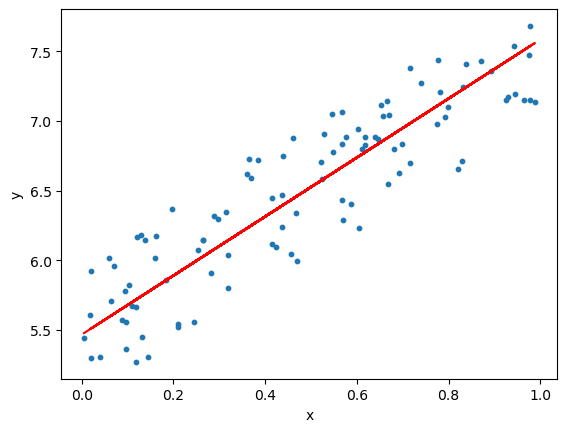

In [13]:
# Plot
plt.scatter(x.data, y.data, s=10)
plt.xlabel('x')
plt.ylabel('y')
y_pred = predict(x)
plt.plot(x.data, y_pred.data, color='r')
plt.show()

## Step 43: Neural networks

前面实现了线性变化，实现中使用了matmul和add函数。会出现一个问题，在计算图存在期间，Variable实例的数据会一直保持在内存中，这会导致内存占用过大。

如果将其封装为一个Linear类，中间结果**没有作为Variable实例存储**，数据在正向传播结束后就会被释放。
<center>
<table>
  <tr>
    <td><img src="./res/linear.png" width="400"/></td>
  </tr>
</table>
</center>

如左上图，+的反向传播仅仅传播输出端的梯度。也就是说，+的反向传播小不需要t的数据。另外，matmul的反向传播只需要输入变量x、W和b，也不需要t的数据。

当然可以通过手动删除中间结果的方式来减少内存占用，但这样会增加代码的复杂度。通过定义Linear类在反向传播时执行+和matmul的反向传播，更加方便。


In [14]:
def linear_simple(x, W, b=None):
    t = F.matmul(x, W)
    if b is None:
        return t
    y = t + b
    t.data = None  # Release t.data (ndarray) for memory efficiency
    return y

下面创建一个非线性数据集，此时不能再用线性回归来处理，需要使用神经网络。

神经网络对线性变化的输出进行非线性变换(激活函数)，典型的激活函数有ReLU、Sigmoid、Tanh等。

In [15]:
# 非线性数据集
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

In [16]:
def sigmoid_simple(x):
    x = F.as_variable(x)
    y = 1 / (1 + F.exp(-x))
    return y

In [17]:
# 权重初始化
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# 神经网络
def predict_simple(x):
    y = linear_simple(x, W1, b1)
    y = sigmoid_simple(y)
    y = linear_simple(y, W2, b2)
    return y

def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8473695850105871)
variable(0.2514286285183606)
variable(0.2475948546674987)
variable(0.23786120447054812)
variable(0.21222231333102917)
variable(0.1674218111783416)
variable(0.09681932619992674)
variable(0.0784952829060233)
variable(0.07749729552991148)
variable(0.07722132399559316)


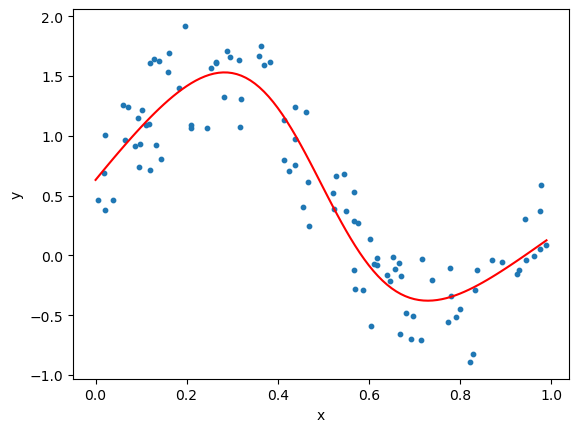

In [18]:
# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

## Step 44: Layer of summary parameters

前面实现神经网络时，对参数的处理（更新梯度）非常枯燥、麻烦，本步骤创建汇总参数的机制。

Parameter类直接继承Variable类，可以用isinstance函数对他们进行区分进而只收集Parameter实例。

In [3]:
x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Variable))
print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
True
False
False


Layer类与Function类相似，都是变化变量的类，但Layer类是持有参数并使用这些参数进行变换的类。

通过__setattr__方法，可以将Parameter实例注册到Layer实例的params属性中。

In [3]:
layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)  # 打印参数的名称
print("----------------")

for name in layer._params:  # 通过dict的方式访问参数
    print(name, layer.__dict__[name])

{'p2', 'p1'}
----------------
p2 variable(2)
p1 variable(1)


给Layer类实现__call__方法、forward方法，接下来就可以继承Layer类实现神经网络的层。

Linear类实现过程有个细节，可以不设置input_size，而是在forward方法中根据输入数据的形状自动设置input_size。

有了Layer类后，清空梯度和更新参数的操作就变得更加清晰。

In [5]:
# 数据集
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

layer1 = L.Linear(10)  # 只指定输出大小
layer2 = L.Linear(1)

def predict(x):
    y = layer1(x)
    y = F.sigmoid(y)
    y = layer2(y)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    layer1.cleargrads()  # 清空梯度
    layer2.cleargrads()
    loss.backward()

    for l in [layer1, layer2]:  # 更新参数
        for p in l.params():
            p.data -= lr * p.grad.data

    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


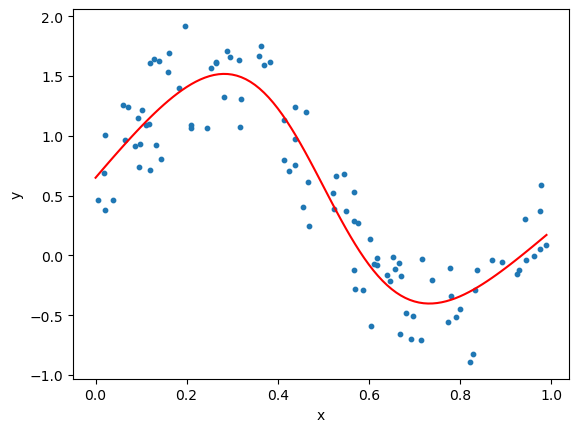

In [6]:
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

## Step 45: Layer of summary layers

前面创建了Layer类来管理参数，但Layer实例本身也需要进行管理，若前一步代码有10个Linear实例，管理起来就会很麻烦。

当前Layer类可以持有多个Parameter，拓展Layer类，使其可以持有其他的Layer。
<center>
<img src="./res/layers.png" width="500"/>
</center>

Layer类变为一个嵌套结构，我们希望在最上层的Layer中取出所有的参数。

主要是在设置实例变量时，将Layer实例的名称也添加到_params中；在取出参数时，递归遍历所有的Layer实例，将参数取出。

In [2]:
model = Layer()
model.l1 = L.Linear(10)
model.l2 = L.Linear(1)

# 进行推理
def predict(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

# 访问参数
for p in model.params():
    print(p)

# 清空梯度
model.cleargrads()

variable([0.])
variable(None)
variable([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
variable(None)


为了更好地抽象描述系统，有必要引入Model类，Model类是Layer的子类，显式管理Layer实例。

为Model类增加了可视化功能，可以将Model实例的结构以图的形式显示出来。

In [2]:
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
model = TwoLayerNet(100, 10)
x = Variable(np.random.randn(5, 100), name='x')
model.plot(x)

In [3]:
# 下面使用Model类训练Sin数据集，代码将简洁很多
# 数据集
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 超参数
lr = 0.2
max_iter = 10000
hidden_size = 10

#model = TwoLayerNet(hidden_size, 1)
# MLP，封装好的更简洁的TwoLayerNet
model = MLP((10, 1))

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()  # 最上层清空梯度
    loss.backward()

    for p in model.params():  # 更新参数
        p.data -= lr * p.grad.data

    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


## Step 46: Update parameters using the Optimizer

除了梯度下降法，还有很多优化方法，将参数更新的工作模块化，创建一个能够轻松切换优化方法的机制。

基类Optimizer类中定义了update方法，汇总所有参数后调用update_one方法。update_one方法是抽象方法，在子类中实现。

In [5]:
# 数据集
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 超参数
lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model)  # 传入model，自动获取所有参数

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()  # 最上层清空梯度
    loss.backward()

    optimizer.update()

    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


## Step 47: Softmax function and cross entropy error

解决了回归问题后，接下来挑战多分类问题。本节为实现多分类做准备。

首先实现切片函数get_item，将多维数组中的一些数据原封不动地传递出去。反向传播时，为被提取部分设置梯度，其他部分的梯度设置为0。

In [2]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.get_item(x, 1)
print(y)
y.backward()
print(x.grad)

variable([4 5 6])
variable([[0 0 0]
          [1 1 1]])


In [3]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
indices = np.array([0, 0, 1])
y = F.get_item(x, indices)
print(y)
y = x[:,2]
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])
variable([3 6])


In [5]:
def softmax_simple(x, axis=1):
    x = F.as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y, axis=axis, keepdims=True)
    return y / sum_y  # 自动广播

model = MLP((10, 3))
x = np.random.rand(5, 10)
y = model(x)
p = softmax_simple(y)
print(p)

variable([[0.27352775 0.18031761 0.54615464]
          [0.25847878 0.1762892  0.56523202]
          [0.26761705 0.15859851 0.57378444]
          [0.24893293 0.17717243 0.57389464]
          [0.25620168 0.17267577 0.57112255]])


线性回归中使用均方根误差，多分类问题中最常用的损失函数是交叉熵误差。
$$
\begin{align*}
L = -\sum_{i} t_i \log y_i
\end{align*}
$$

可以简化为提取正确标签的元素，然后计算其负对数似然。
$$
\begin{align*}
L = -\log y_{t}
\end{align*}
$$

In [7]:
def softmax_cross_entropy_simple(x, t):
    x, t = F.as_variable(x), F.as_variable(t)
    N = x.shape[0]  # batch size
    p = softmax_simple(x)
    p = F.clip(p, 1e-15, 1.0)  # 防止log(0)的发生
    log_p = F.log(p)
    tlog_p = log_p[np.arange(N), t.data]  # 通过数组索引取出对应的元素
    return -F.sum(tlog_p) / N

x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])
t = np.array([2,0,1,0])
model = MLP((2, 3))
y = model(x)
loss = softmax_cross_entropy_simple(y, t)
print(loss)


variable(1.07653982773381)


## Step 48: Multi-class classification

前面实现了Softmax函数和交叉熵误差，接下来尝试解决多分类问题。

(300, 2)
(300,)


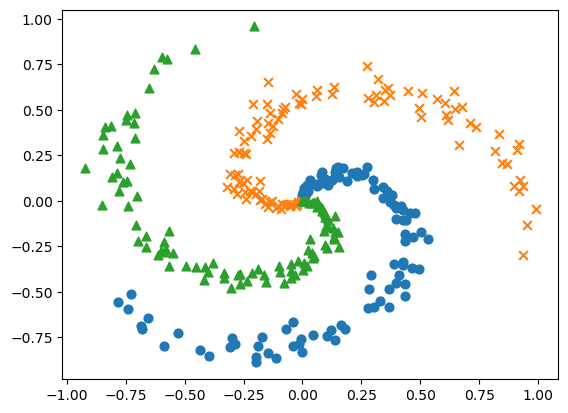

In [2]:
def get_spiral(train=True):
    seed = 1984 if train else 2020
    np.random.seed(seed=seed)

    num_data, num_class, input_dim = 100, 3, 2
    data_size = num_class * num_data
    x = np.zeros((data_size, input_dim), dtype=np.float32)
    t = np.zeros(data_size, dtype=int)

    for j in range(num_class):
        for i in range(num_data):
            rate = i / num_data
            radius = 1.0 * rate
            theta = j * 4.0 + 4.0 * rate + np.random.randn() * 0.2
            ix = num_data * j + i
            x[ix] = np.array([radius * np.sin(theta),
                              radius * np.cos(theta)]).flatten()
            t[ix] = j
    # Shuffle
    indices = np.random.permutation(num_data * num_class)
    x = x[indices]
    t = t[indices]
    return x, t

x, t = get_spiral(train=True)
print(x.shape)
print(t.shape)

# 二维数据集，根据label绘制不同颜色
N = x.shape[0]
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[t==i][:, 0], x[t==i][:, 1], s=40, marker=markers[i])
plt.show()

In [7]:
# 超参数
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# 读入数据
x, t = get_spiral(train=True)

# 模型和优化器
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

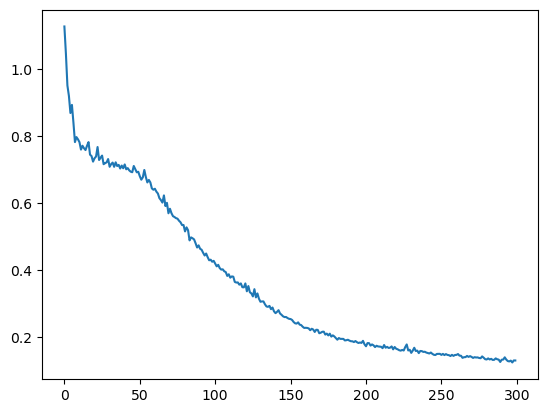

In [8]:
data_size = len(x)
max_iter = math.ceil(data_size / batch_size)  # 向上取整
losses = []

for epoch in range(max_epoch):
    # 随机打乱数据
    index = np.random.permutation(data_size)  # 打乱索引
    sum_loss = 0

    for i in range(max_iter):
        # 创建mini-batch
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        # 计算梯度，更新参数
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # 输出每个epoch的损失
    avg_loss = sum_loss / data_size
    #print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))
    losses.append(avg_loss)

# 绘制损失曲线
plt.plot(losses)

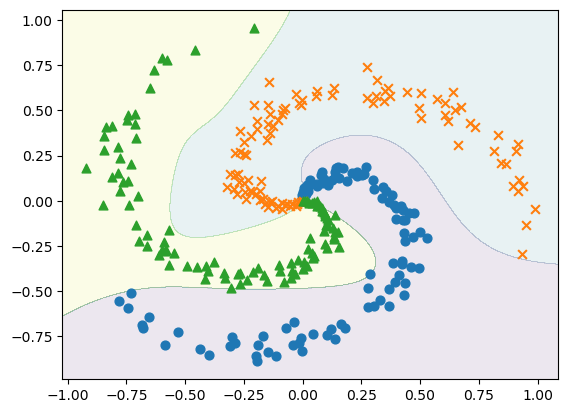

In [9]:
# 绘制决策边界
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
y = model(X)
y = y.data
predict_cls = y.argmax(axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.1)
for i in range(CLS_NUM):
    plt.scatter(x[t==i][:, 0], x[t==i][:, 1], s=40, marker=markers[i])
plt.show()

## Step 49: Dataset and preprocessing

上一步骤的get_spiral函数把数据都保存到了一个ndarray实例中，当数据集过大时，这种方法会导致内存不足。实现Dataset类来更好地管理数据。

基类Dataset类使用data和label保存数据与标签，实现get_item方法，可以通过索引获取数据。

子类实现prepare函数用来准备数据，将数据集分为训练集和测试集。

对于很大的数据集，使用np.load函数在访问数据时加载数据，这样可以减少内存占用。

In [2]:
train_set = datasets.Spiral(train=True)
print(len(train_set))
print(train_set[0])

300
(array([-0.13981389, -0.00721657], dtype=float32), 1)


In [4]:
# 通过索引操作提取小批量数据
batch_index = [0, 1, 2]
batch = [train_set[i] for i in batch_index]
# 将小批量数据转换为NumPy数组
x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])
print(x.shape)
print(t.shape)

(3, 2)
(3,)


在向模型输入数据之前，通常需要进行一定的处理，比如数据增强等操作，需要向Dataset类中添加预处理功能。

## Step 50: DataLoader for fetching small batches of data

本步骤实现DataLoader类，用于完成创建小批量数据和数据集重排等工作。

本质是实现一个迭代器，每次返回一个小批量数据。

In [1]:
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration()
        self.cnt += 1
        return self.cnt
    
obj = MyIterator(5)
for x in obj:
    print(x)

1
2
3
4
5


In [2]:
# 如何使用DataLoader
batch_size = 10
max_epoch = 1

train_set = datasets.Spiral(train=True)
test_set = datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape)
        break

    for x, t in test_loader:
        print(x.shape, t.shape)
        break

(10, 2) (10,)
(10, 2) (10,)


下面完整地使用dataset和dataloader来执行spiral数据集的多分类任务。

In [ ]:
# 超参数
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# 读入数据
train_set = datasets.Spiral(train=True)
test_set = datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

# 模型和优化器
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

# 训练模型
test_losses = []
test_accuracies = []
for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:  # 从DataLoader中取出小批量数据
        # 使用模型进行预测
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)  # 计算损失
        acc = F.accuracy(y, t)  # 计算精度

        # 反向传播，更新参数
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():  # 不进行梯度计算，节省反向传播的时间和内存
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(sum_loss / len(test_set), sum_acc / len(test_set)))
    test_losses.append(sum_loss / len(test_set))
    test_accuracies.append(sum_acc / len(test_set))

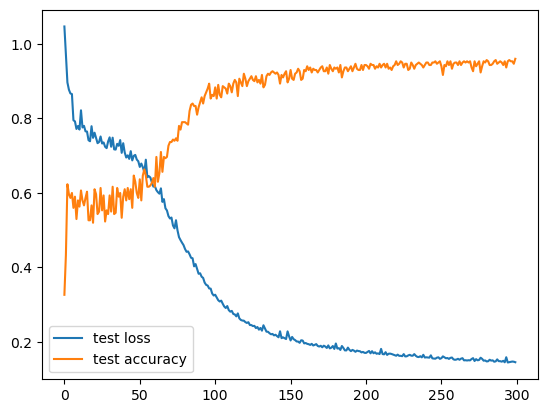

In [4]:
# train loss: 0.1082, accuracy: 0.9667
# test loss: 0.1458, accuracy: 0.9600
# 绘制损失曲线与精度曲线于一张图
plt.plot(test_losses, label='test loss')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()

## Step 51: MNIST

Dataset类统一了数据集的处理，数据集的预处理在Dataset类中完成，最后Dataloader从Dataset中取出小批量数据。
<center>
<img src="./res/dataset.png" width="500"/>
</center>

In [2]:
train_set = datasets.MNIST(train=True, transform=None)
test_set = datasets.MNIST(train=False, transform=None)

print(len(train_set))
print(len(test_set))

x, y = train_set[0]
print(type(x), x.shape)
print(y)

60000
10000
<class 'numpy.ndarray'> (1, 28, 28)
5


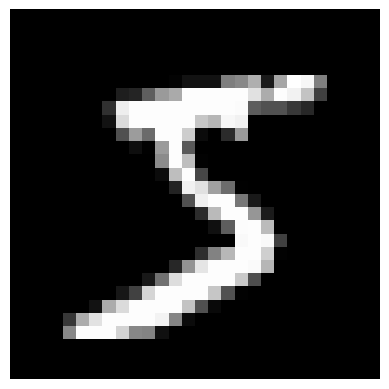

label: 5


In [4]:
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', y)

In [6]:
# 超参数
max_epoch = 5
batch_size = 100
hidden_size = 1000

# 读入数据
train_set = datasets.MNIST(train=True)
test_set = datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

# 模型和优化器
#model = MLP((hidden_size, 10))
model = MLP((hidden_size, hidden_size//2, 10), activation=F.relu)
optimizer = optimizers.Adam().setup(model)

# 训练模型
for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)

        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 0.1968, accuracy: 0.9409
test loss: 0.1085, accuracy: 0.9644
epoch: 2
train loss: 0.0743, accuracy: 0.9766
test loss: 0.0758, accuracy: 0.9778
epoch: 3
train loss: 0.0470, accuracy: 0.9849
test loss: 0.0727, accuracy: 0.9790
epoch: 4
train loss: 0.0348, accuracy: 0.9887
test loss: 0.0974, accuracy: 0.9735
epoch: 5
train loss: 0.0273, accuracy: 0.9912
test loss: 0.0678, accuracy: 0.9796
